# Homework 7 | AI 231 | Michael Spencer Quinto

Presentation

Dataset: Brain Tumor Medical Image Classification


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import cv2
import torch

from tqdm import tqdm
from IPython.display import display
from pathlib import Path
from torchvision.models import (
    EfficientNet_B0_Weights,
    MobileNet_V3_Large_Weights,
    ResNet50_Weights,
    VGG19_Weights,
    efficientnet_b0,
    mobilenet_v3_large,
    resnet50,
    vgg19,
)
from torchinfo import summary

from utils import (
    test_model,
    plot_confusion_matrix,
    plot_roc_curves
)


%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=3)

In [2]:
from hw_7_training import show_one_image_per_category

In [3]:
# dataset: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri?resource=download:


training_file_path = Path("./brain_tumor_dataset/Training")
testing_file_path = Path("./brain_tumor_dataset/Testing")

# EDA


In [4]:
train_images_counts = {}
test_images_counts = {}

categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Training
for category in categories:
    # print(category)
    train_category_path = training_file_path / category
    test_category_path = testing_file_path / category

    train_num_images = len(list(train_category_path.glob("*.jpg")))
    train_images_counts[category] = train_num_images

    test_num_images = len(list(test_category_path.glob("*.jpg")))
    test_images_counts[category] = test_num_images

In [5]:
print(train_images_counts)
print(test_images_counts)

{'glioma_tumor': 826, 'meningioma_tumor': 822, 'no_tumor': 395, 'pituitary_tumor': 827}
{'glioma_tumor': 100, 'meningioma_tumor': 115, 'no_tumor': 105, 'pituitary_tumor': 74}


In [6]:
def plot_counts(counts, title):
    plt.figure(figsize=(10, 6))
    plt.bar(counts.keys(), counts.values())
    plt.title(title)
    plt.xlabel("Categories")
    plt.ylabel("Number of Images")
    plt.show()

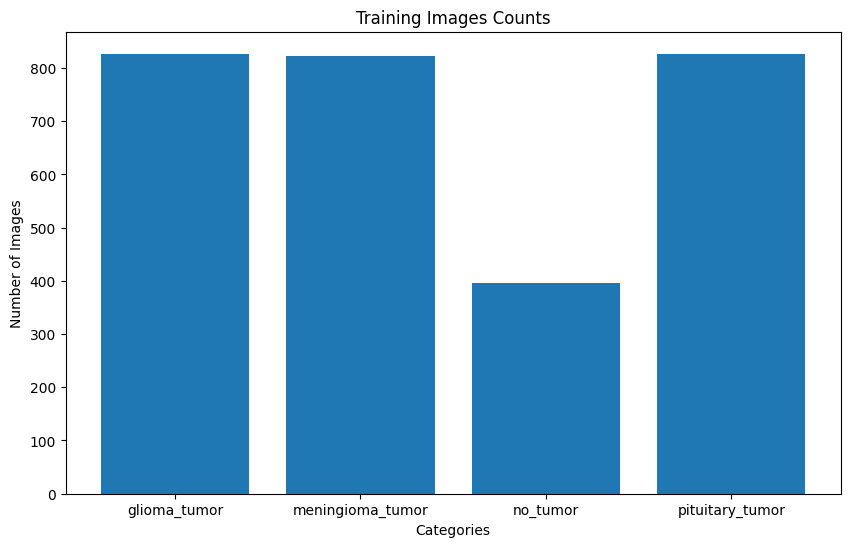

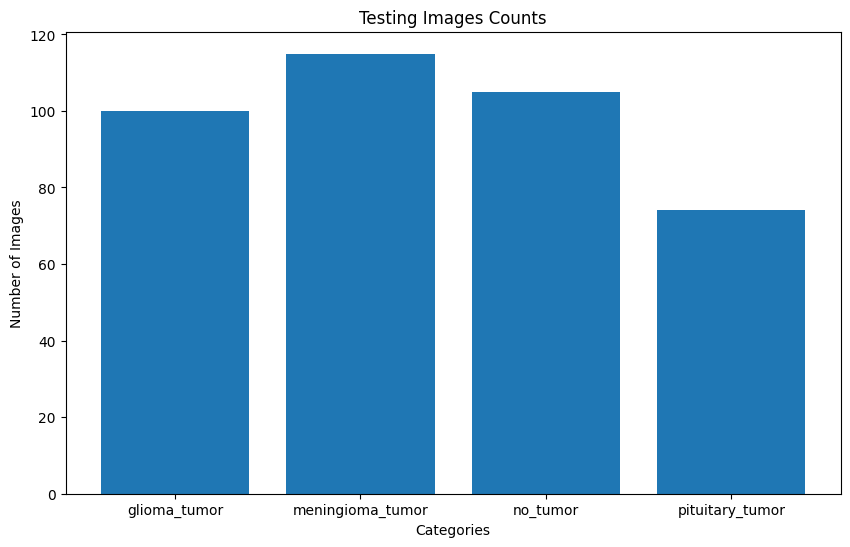

In [7]:
# Train Counts
plot_counts(train_images_counts, "Training Images Counts")

# Test Counts
plot_counts(test_images_counts, "Testing Images Counts")

In [39]:
import random


def plot_images(path: Path, categories: list[str], num_samples: int = 5):
    plt.figure(figsize=(15, 10))

    for i, category in enumerate(categories):
        category_path = path / category
        images = list(category_path.glob("*.jpg"))
        sample_images = random.sample(images, num_samples)

        for j, image in enumerate(sample_images):
            plt.subplot(num_samples, len(categories), i * len(categories) + j + 1)
            plt.imshow(plt.imread(image))
            plt.title(category)
            plt.axis("off")

    plt.tight_layout()
    plt.show()

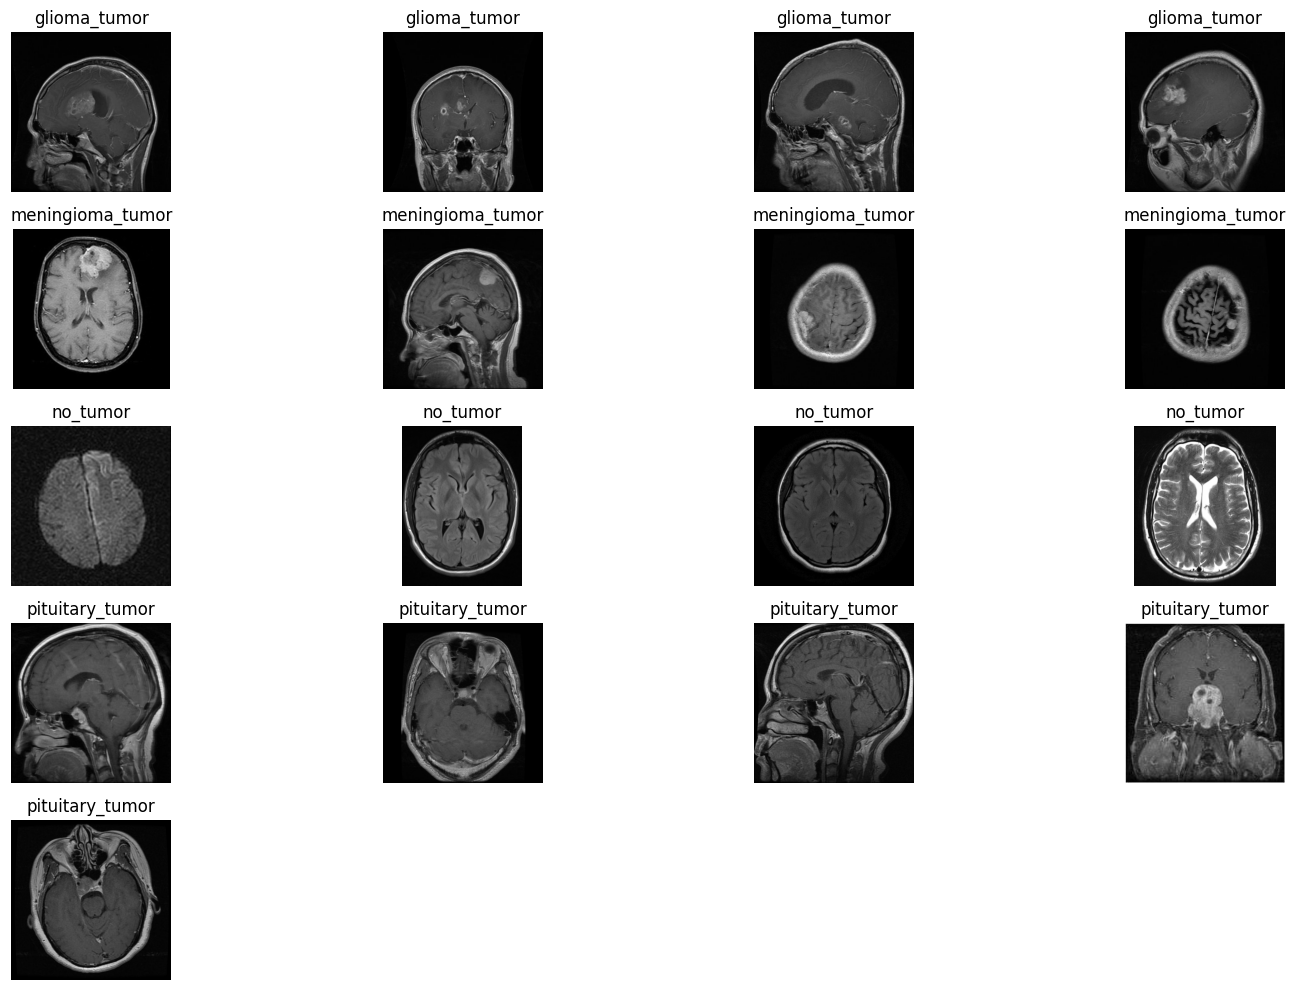

In [40]:
# sample 1
plot_images(training_file_path, categories)

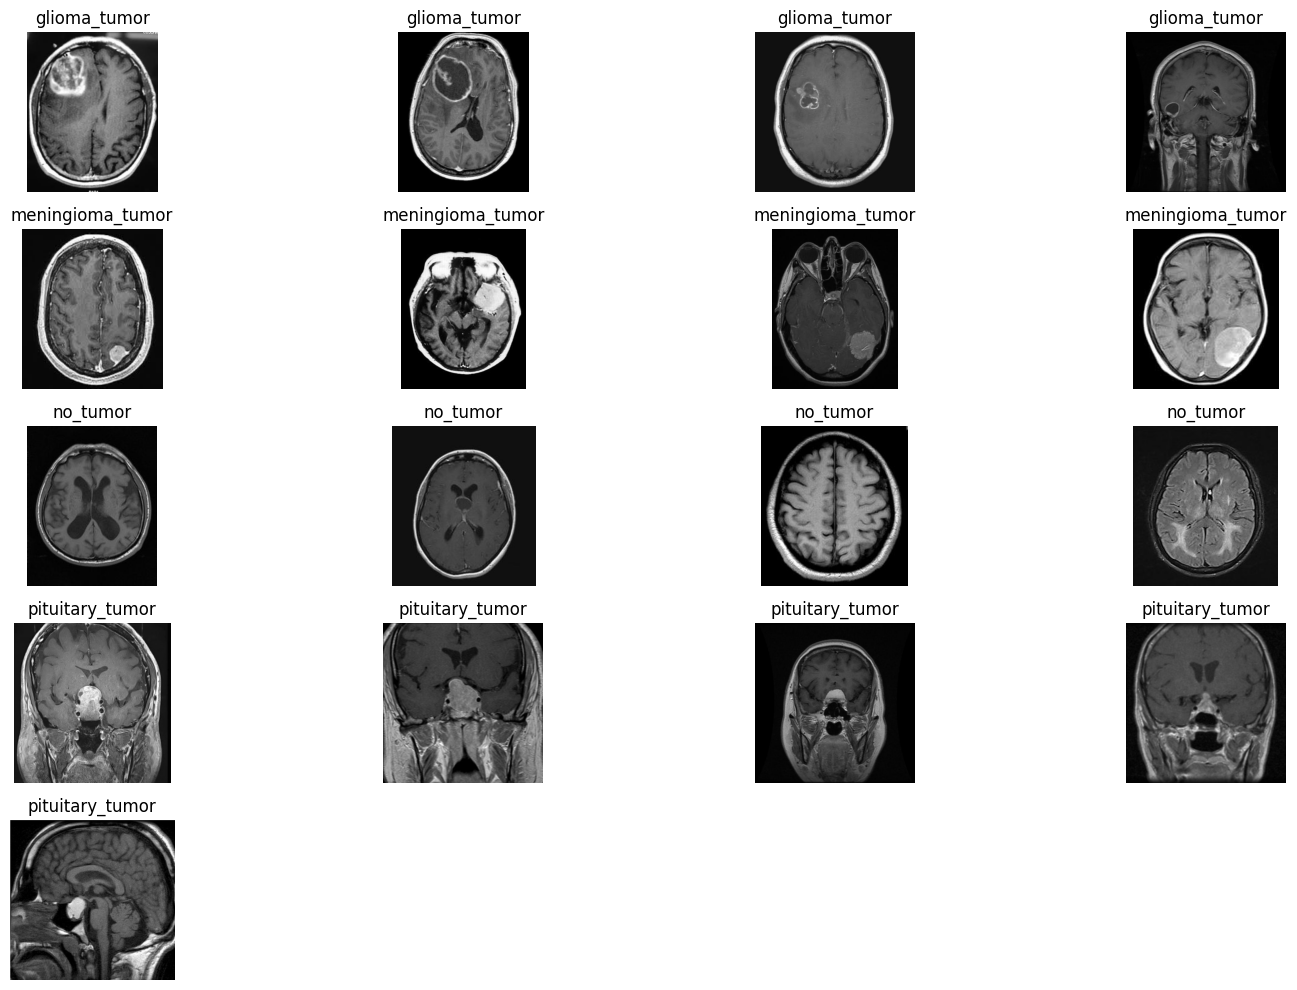

In [41]:
# sample 2
plot_images(testing_file_path, categories)

# Data Prep


In [ ]:
# # Vectorize and resize the images in preparation for training

# X_train = []
# y_train = []
# X_test = []
# y_test = []

# image_size = 150
# # Training
# for i in categories:
#     folderPath = training_file_path / i
#     for j in tqdm(folderPath.glob("*.jpg")):
#         # print(j)
#         # img = cv2.imread(os.path.join(folderPath, j))
#         img = cv2.imread(j)
#         img = cv2.resize(img, (image_size, image_size))
#         X_train.append(img)
#         y_train.append(i)

# # Testing
# for i in categories:
#     folderPath = testing_file_path / i
#     for j in tqdm(folderPath.glob("*.jpg")):
#         # img = cv2.imread(os.path.join(folderPath, j))
#         img = cv2.imread(j)
#         img = cv2.resize(img, (image_size, image_size))
#         X_test.append(img)
#         y_test.append(i)

# X_train = np.array(X_train)
# y_train = np.array(y_train)

# X_test = np.array(X_test)
# y_test = np.array(y_test)

# print("Training Data, Shape:")
# display(X_train.shape)
# # print(X_train[:5])
# display(y_train.shape)
# print(y_train[:5])
# print("Testing Data, Shape:")
# display(X_test.shape)
# # print(X_test[:5])
# display(y_test.shape)
# print(y_test[:5])

826it [00:00, 1151.04it/s]
822it [00:00, 1215.85it/s]
395it [00:00, 1318.61it/s]
827it [00:00, 1042.25it/s]
100it [00:00, 1155.32it/s]
115it [00:00, 1522.03it/s]
105it [00:00, 2742.47it/s]
74it [00:00, 484.78it/s]


Training Data, Shape:


(2870, 150, 150, 3)

(2870,)

['glioma_tumor' 'glioma_tumor' 'glioma_tumor' 'glioma_tumor'
 'glioma_tumor']
Testing Data, Shape:


(394, 150, 150, 3)

(394,)

['glioma_tumor' 'glioma_tumor' 'glioma_tumor' 'glioma_tumor'
 'glioma_tumor']


In [15]:
from sklearn.model_selection import train_test_split

# Assuming categories, training_file_path, testing_file_path, and image_size are defined

# Vectorize and resize the images in preparation for training

X_train = []
y_train = []
X_test = []
y_test = []

# Training
for i in categories:
    folderPath = training_file_path / i
    for j in tqdm(folderPath.glob("*.jpg")):
        img = cv2.imread(str(j))  # Convert Path object to string
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

# Testing
for i in categories:
    folderPath = testing_file_path / i
    for j in tqdm(folderPath.glob("*.jpg")):
        img = cv2.imread(str(j))  # Convert Path object to string
        img = cv2.resize(img, (image_size, image_size))
        X_test.append(img)
        y_test.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Combine X_train and X_test, y_train and y_test
X_combined = np.concatenate((X_train, X_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

# Re-partition into 80-20, with shuffling
X_train, X_test, y_train, y_test = train_test_split(
    X_combined,
    y_combined,
    test_size=0.2,
    shuffle=True,
    random_state=42,  # Added random_state for reproducibility
)

print("New Training Data, Shape:")
display(X_train.shape)
display(y_train.shape)
print(y_train[:5])
print("New Testing Data, Shape:")
display(X_test.shape)
display(y_test.shape)
print(y_test[:5])

826it [00:00, 1139.48it/s]
822it [00:00, 1220.09it/s]
395it [00:00, 1304.89it/s]
827it [00:00, 1040.79it/s]
100it [00:00, 1140.48it/s]
115it [00:00, 1536.59it/s]
105it [00:00, 2729.82it/s]
74it [00:00, 487.45it/s]


New Training Data, Shape:


(2611, 150, 150, 3)

(2611,)

['glioma_tumor' 'no_tumor' 'glioma_tumor' 'glioma_tumor' 'glioma_tumor']
New Testing Data, Shape:


(653, 150, 150, 3)

(653,)

['meningioma_tumor' 'glioma_tumor' 'glioma_tumor' 'glioma_tumor'
 'meningioma_tumor']


# Image from the vectorized 150x150 np arrays


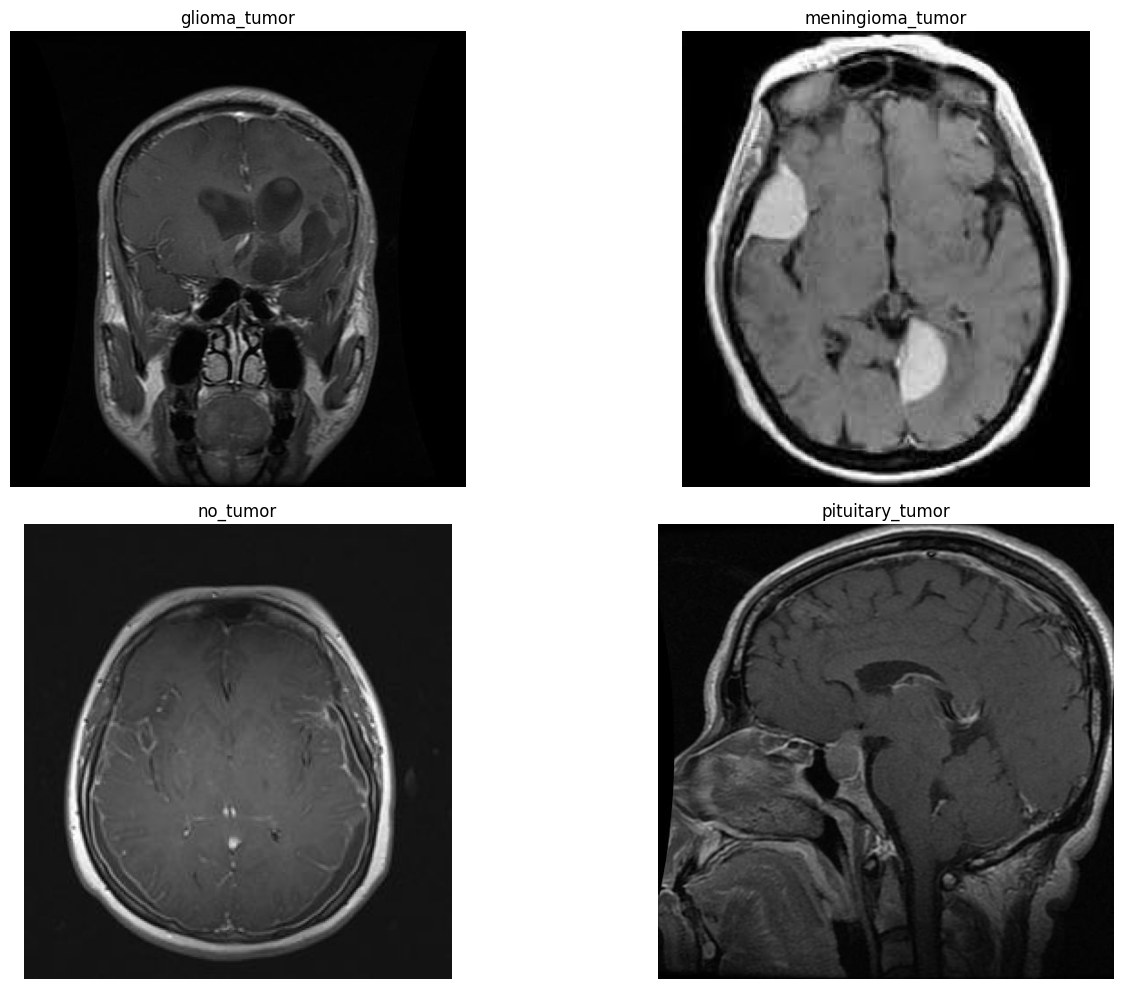

In [43]:
show_one_image_per_category(
    categories,
    training_file_path,
)

In [11]:
print(y_train[:15])
print(y_train[1500:1515])
print(y_test[:15])

['glioma_tumor' 'no_tumor' 'glioma_tumor' 'glioma_tumor' 'glioma_tumor'
 'no_tumor' 'pituitary_tumor' 'glioma_tumor' 'meningioma_tumor'
 'glioma_tumor' 'meningioma_tumor' 'glioma_tumor' 'glioma_tumor'
 'pituitary_tumor' 'pituitary_tumor']
['meningioma_tumor' 'glioma_tumor' 'glioma_tumor' 'glioma_tumor'
 'pituitary_tumor' 'glioma_tumor' 'pituitary_tumor' 'glioma_tumor'
 'meningioma_tumor' 'meningioma_tumor' 'meningioma_tumor'
 'pituitary_tumor' 'glioma_tumor' 'meningioma_tumor' 'no_tumor']
['meningioma_tumor' 'glioma_tumor' 'glioma_tumor' 'glioma_tumor'
 'meningioma_tumor' 'meningioma_tumor' 'meningioma_tumor'
 'meningioma_tumor' 'glioma_tumor' 'glioma_tumor' 'no_tumor' 'no_tumor'
 'meningioma_tumor' 'pituitary_tumor' 'meningioma_tumor']


# Encoding the Categories/Labels


In [12]:
from sklearn.preprocessing import LabelEncoder

# Create and fit the encoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# display first few encoded labels
print(y_train_encoded[:15])
print(y_train_encoded[1500:1515])
print(y_test_encoded[:15])

# show the equivalent of the numbers to the categories (only the unique values)
for class_label in label_encoder.classes_:
    encoded_value = label_encoder.transform([class_label])[0]
    print(f"{class_label}: {encoded_value}")

[0 2 0 0 0 2 3 0 1 0 1 0 0 3 3]
[1 0 0 0 3 0 3 0 1 1 1 3 0 1 2]
[1 0 0 0 1 1 1 1 0 0 2 2 1 3 1]
glioma_tumor: 0
meningioma_tumor: 1
no_tumor: 2
pituitary_tumor: 3


# Load Data from saved file


In [13]:
TRAINING_DATA_PATH = Path("./training_data")


from utils import (
    TumorClassifier,
    TumorDataset,
    encode_labels,
    load_and_preprocess_images,
    load_model_weights,
    load_preprocessed_data,
    save_preprocessed_data,
    test_model,
    train_model,
)

In [16]:
# NOTE: important: do not do (this is the old unshuffled dataset)
# X_train, y_train, X_test, y_test = load_preprocessed_data(TRAINING_DATA_PATH)

# Loaded data from files
print("Training Data, Shape:")
print(X_train.shape)
# print(X_train[:5])
print(y_train.shape)
print(y_train[:5])
print("Testing Data, Shape:")
print(X_test.shape)
# print(X_test[:5])
print(y_test.shape)
print(y_test[:5])

Training Data, Shape:
(2611, 150, 150, 3)
(2611,)
['glioma_tumor' 'no_tumor' 'glioma_tumor' 'glioma_tumor' 'glioma_tumor']
Testing Data, Shape:
(653, 150, 150, 3)
(653,)
['meningioma_tumor' 'glioma_tumor' 'glioma_tumor' 'glioma_tumor'
 'meningioma_tumor']


# Label Encoding


In [17]:
# Encode the labels
y_train_encoded, y_test_encoded = encode_labels(y_train, y_test)
train_dataset = TumorDataset(X_train, y_train_encoded)
test_dataset = TumorDataset(X_test, y_test_encoded)

Encoded labels
glioma_tumor: 0
meningioma_tumor: 1
no_tumor: 2
pituitary_tumor: 3


# Effnet


***** Training EffNet *****


Epoch 1/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 77.06it/s, loss=0.9425, acc=85.25%]



Epoch 1/12:
Training Loss: 0.9873, Training Accuracy: 77.02%
Validation Loss: 0.8986, Validation Accuracy: 85.25%



Epoch 2/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 72.22it/s, loss=0.9437, acc=87.74%]



Epoch 2/12:
Training Loss: 0.9021, Training Accuracy: 83.72%
Validation Loss: 0.8671, Validation Accuracy: 87.74%



Epoch 3/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 71.39it/s, loss=0.8550, acc=87.55%]



Epoch 3/12:
Training Loss: 0.8928, Training Accuracy: 85.30%
Validation Loss: 0.8689, Validation Accuracy: 87.55%



Epoch 4/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 71.02it/s, loss=0.8444, acc=85.63%]



Epoch 4/12:
Training Loss: 0.8672, Training Accuracy: 87.51%
Validation Loss: 0.8829, Validation Accuracy: 85.63%



Epoch 5/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 73.14it/s, loss=0.7438, acc=87.55%]



Epoch 5/12:
Training Loss: 0.8578, Training Accuracy: 88.75%
Validation Loss: 0.8579, Validation Accuracy: 87.55%



Epoch 6/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 76.52it/s, loss=0.9439, acc=89.08%]



Epoch 6/12:
Training Loss: 0.8748, Training Accuracy: 86.50%
Validation Loss: 0.8529, Validation Accuracy: 89.08%



Epoch 7/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 74.06it/s, loss=0.9438, acc=94.06%]



Epoch 7/12:
Training Loss: 0.8413, Training Accuracy: 90.57%
Validation Loss: 0.8123, Validation Accuracy: 94.06%



Epoch 8/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 76.88it/s, loss=0.8498, acc=93.87%]



Epoch 8/12:
Training Loss: 0.8307, Training Accuracy: 91.14%
Validation Loss: 0.8059, Validation Accuracy: 93.87%



Epoch 9/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 71.17it/s, loss=0.9437, acc=87.16%]



Epoch 9/12:
Training Loss: 0.8313, Training Accuracy: 91.19%
Validation Loss: 0.8715, Validation Accuracy: 87.16%



Epoch 10/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 73.46it/s, loss=0.8437, acc=90.04%]



Epoch 10/12:
Training Loss: 0.8341, Training Accuracy: 90.71%
Validation Loss: 0.8441, Validation Accuracy: 90.04%



Epoch 11/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 34.87it/s, loss=0.8441, acc=94.06%]



Epoch 11/12:
Training Loss: 0.8231, Training Accuracy: 92.10%
Validation Loss: 0.8070, Validation Accuracy: 94.06%



Epoch 12/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 73.55it/s, loss=0.8437, acc=94.44%]



Epoch 12/12:
Training Loss: 0.7965, Training Accuracy: 94.78%
Validation Loss: 0.8012, Validation Accuracy: 94.44%



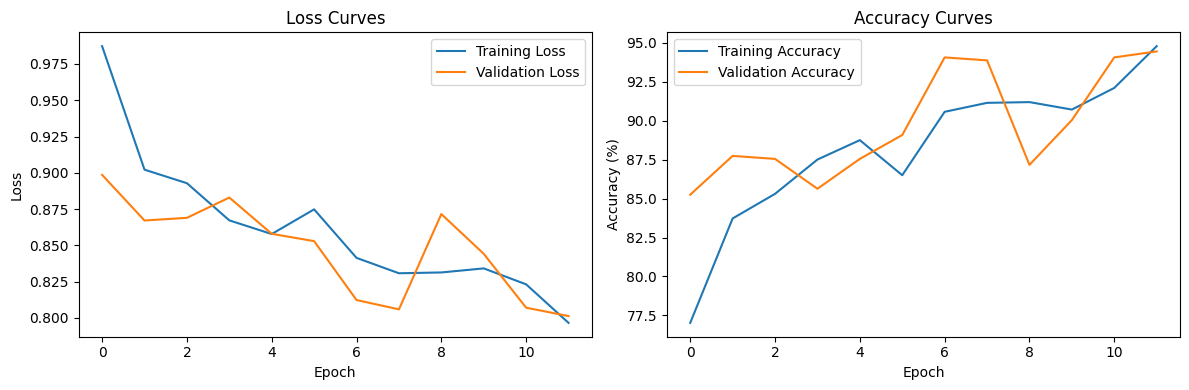

Saving model weights to ./training_data/effnet_weights.pth


In [20]:
model_effnet = TumorClassifier(
    num_classes=4,
    pretrained_model=efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1),
)  # 2 classes for your tumor types
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_effnet = model_effnet.to(device)
summary(model_effnet, input_size=(1, 3, 224, 224))
print("***** Training EffNet *****")
# Training and saving weights (effnet)
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model_effnet,
    train_dataset,
    batch_size=32,
    epochs=12,
    val_split=0.2,
    lr=0.001,
    save_path="./training_data/effnet_weights.pth",
)

# Resnet


***** Training ResNet *****


Epoch 1/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 80.95it/s, loss=1.2289, acc=33.52%]



Epoch 1/12:
Training Loss: 1.1126, Training Accuracy: 61.75%
Validation Loss: 1.3985, Validation Accuracy: 33.52%



Epoch 2/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 86.24it/s, loss=1.3016, acc=49.04%]



Epoch 2/12:
Training Loss: 1.1123, Training Accuracy: 62.42%
Validation Loss: 1.2461, Validation Accuracy: 49.04%



Epoch 3/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 87.06it/s, loss=1.4265, acc=51.53%]



Epoch 3/12:
Training Loss: 1.0943, Training Accuracy: 64.00%
Validation Loss: 1.2311, Validation Accuracy: 51.53%



Epoch 4/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 87.22it/s, loss=1.2923, acc=65.13%]



Epoch 4/12:
Training Loss: 1.0561, Training Accuracy: 68.31%
Validation Loss: 1.0993, Validation Accuracy: 65.13%



Epoch 5/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 89.29it/s, loss=1.4291, acc=54.79%]



Epoch 5/12:
Training Loss: 1.0552, Training Accuracy: 68.17%
Validation Loss: 1.2033, Validation Accuracy: 54.79%



Epoch 6/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 89.33it/s, loss=1.1567, acc=65.33%]



Epoch 6/12:
Training Loss: 1.0560, Training Accuracy: 68.98%
Validation Loss: 1.0873, Validation Accuracy: 65.33%



Epoch 7/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 55.64it/s, loss=1.1412, acc=58.62%]



Epoch 7/12:
Training Loss: 1.0362, Training Accuracy: 70.03%
Validation Loss: 1.1506, Validation Accuracy: 58.62%



Epoch 8/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 88.85it/s, loss=1.2053, acc=65.13%]



Epoch 8/12:
Training Loss: 1.0110, Training Accuracy: 73.19%
Validation Loss: 1.0900, Validation Accuracy: 65.13%



Epoch 9/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 86.87it/s, loss=1.4437, acc=46.93%]



Epoch 9/12:
Training Loss: 1.0080, Training Accuracy: 73.43%
Validation Loss: 1.2790, Validation Accuracy: 46.93%



Epoch 10/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 87.51it/s, loss=1.0739, acc=70.50%]



Epoch 10/12:
Training Loss: 0.9991, Training Accuracy: 74.15%
Validation Loss: 1.0395, Validation Accuracy: 70.50%



Epoch 11/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 85.54it/s, loss=1.3845, acc=59.20%]



Epoch 11/12:
Training Loss: 1.0502, Training Accuracy: 69.08%
Validation Loss: 1.1535, Validation Accuracy: 59.20%



Epoch 12/12 [Val]: 100%|██████████| 17/17 [00:00<00:00, 86.80it/s, loss=1.2296, acc=64.37%]



Epoch 12/12:
Training Loss: 1.0453, Training Accuracy: 69.17%
Validation Loss: 1.0977, Validation Accuracy: 64.37%



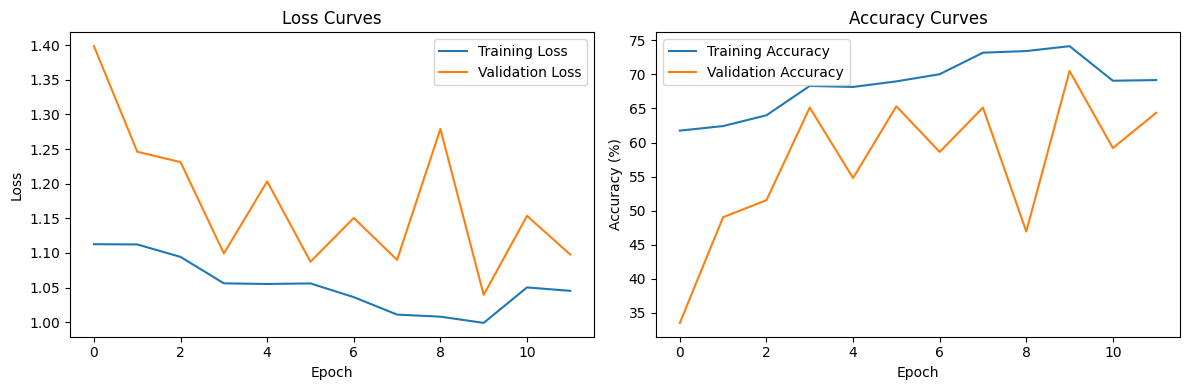

Saving model weights to ./training_data/resnet_weights.pth


In [23]:
#
# ResNet
#
model_resnet = TumorClassifier(
    num_classes=4,
    pretrained_model=resnet50(weights=ResNet50_Weights.IMAGENET1K_V1),
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)
print("***** Training ResNet *****")
# training resnet
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model_resnet,
    train_dataset,
    batch_size=32,
    epochs=12,
    val_split=0.2,
    lr=0.001,
    save_path="./training_data/resnet_weights.pth",
)

# Loading the model from the saved weights


In [21]:
from sklearn.preprocessing import LabelEncoder

print(type(y_test))
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

test_dataset = TumorDataset(X_test, y_test_encoded)

<class 'numpy.ndarray'>


Test Loss: 0.8203
Test Accuracy: 91.88%

Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0     0.9442    0.9269    0.9355       219
     Class 1     0.9398    0.8342    0.8839       187
     Class 2     0.8842    0.9655    0.9231        87
     Class 3     0.8870    0.9812    0.9318       160

    accuracy                         0.9188       653
   macro avg     0.9138    0.9270    0.9185       653
weighted avg     0.9209    0.9188    0.9181       653



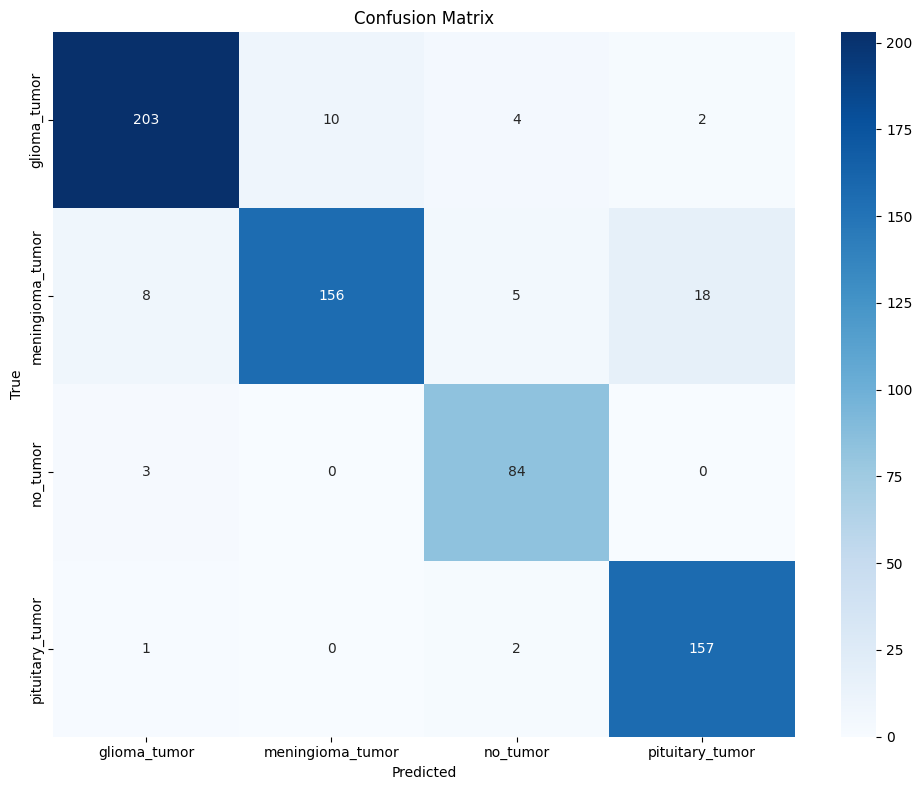

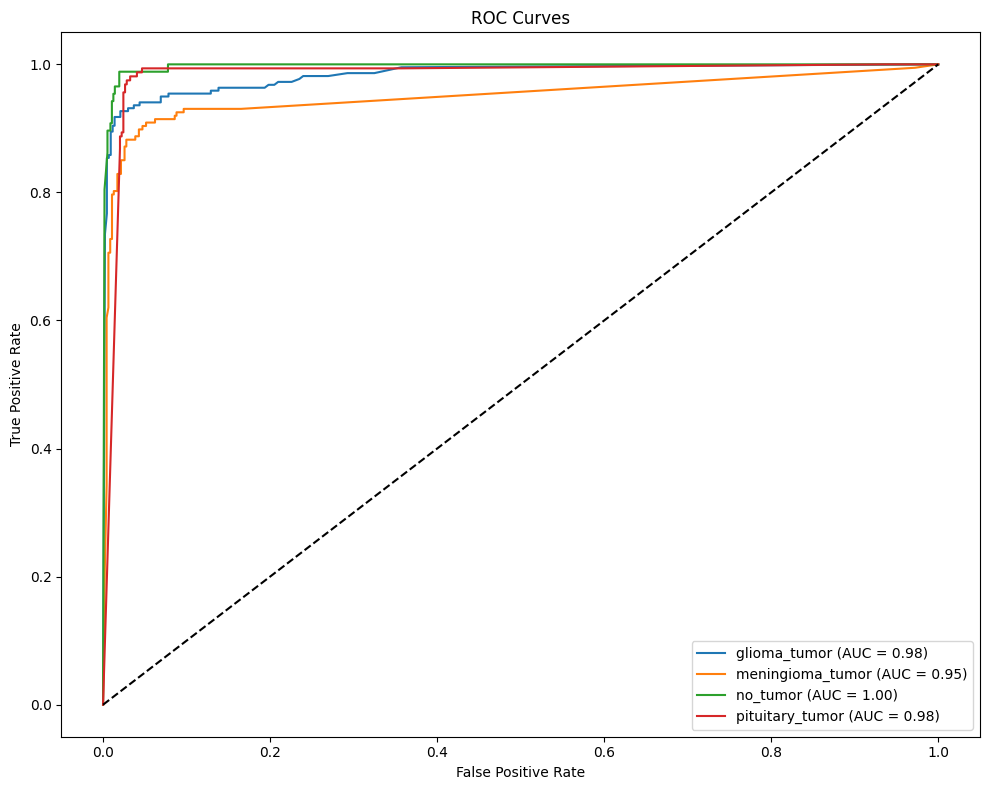

In [22]:
# Later, to load the weights into a new model:
loaded_effnet = load_model_weights(model_effnet, "./training_data/effnet_weights.pth")

# 2. Test the model and get all metrics
test_loss, test_accuracy, class_report, predictions, true_labels, probabilities = (
    test_model(model=loaded_effnet, test_dataset=test_dataset, batch_size=32)
)

# 3. Print the numerical results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print("\nDetailed Classification Report:")
print(class_report)

# 4. Create visualizations
class_names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Plot confusion matrix
plot_confusion_matrix(true_labels, predictions, class_names)

# Plot ROC curves
plot_roc_curves(true_labels, probabilities, class_names)

Test Loss: 1.1343
Test Accuracy: 59.72%

Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8986    0.6073    0.7248       219
     Class 1     0.5329    0.4759    0.5028       187
     Class 2     0.3247    0.8621    0.4717        87
     Class 3     0.8692    0.5813    0.6966       160

    accuracy                         0.5972       653
   macro avg     0.6564    0.6316    0.5990       653
weighted avg     0.7102    0.5972    0.6206       653



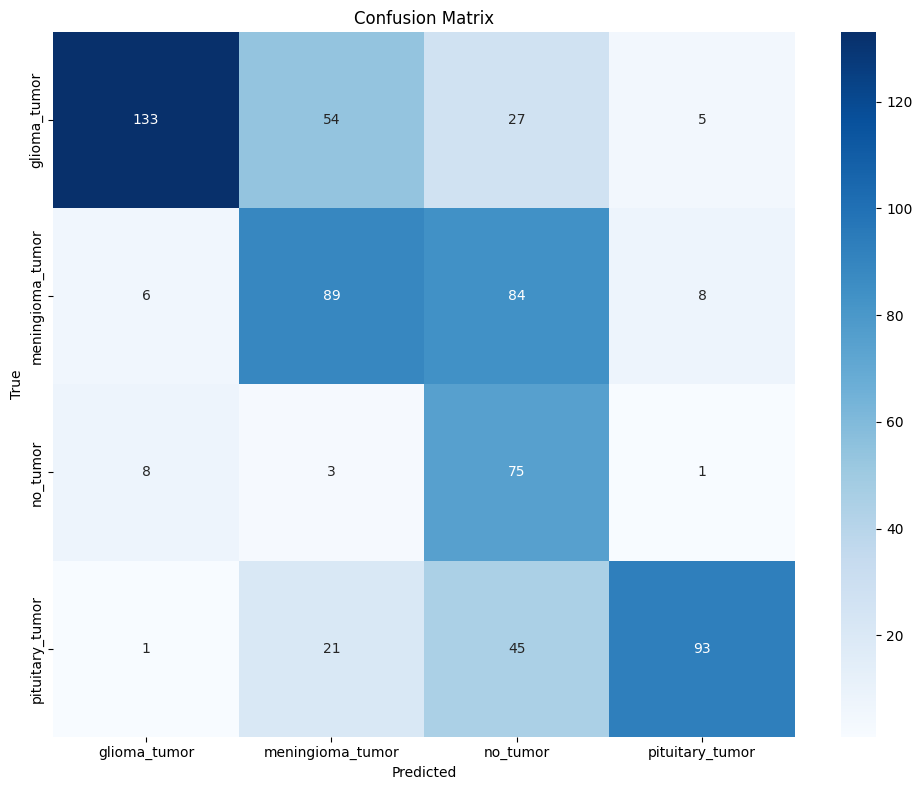

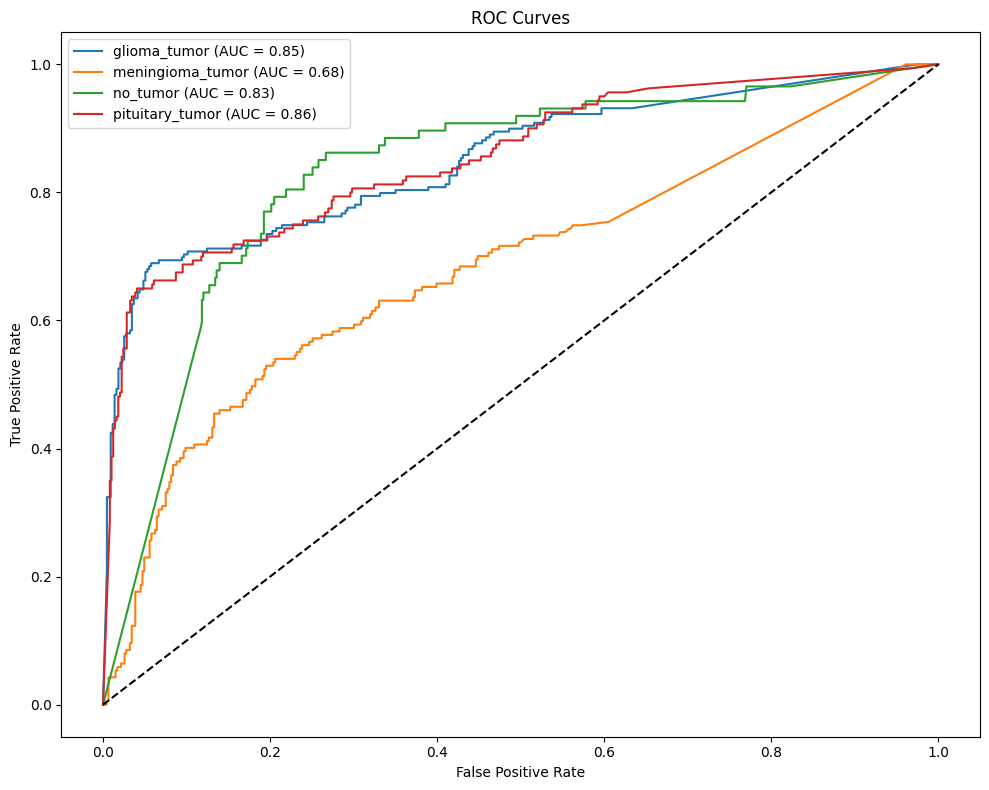

In [24]:
# Later, to load the weights into a new model:
loaded_resnet = load_model_weights(model_resnet, "./training_data/resnet_weights.pth")

# 2. Test the model and get all metrics
test_loss, test_accuracy, class_report, predictions, true_labels, probabilities = (
    test_model(model=loaded_resnet, test_dataset=test_dataset, batch_size=32)
)

# 3. Print the numerical results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print("\nDetailed Classification Report:")
print(class_report)

# 4. Create visualizations
class_names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Plot confusion matrix
plot_confusion_matrix(true_labels, predictions, class_names)

# Plot ROC curves
plot_roc_curves(true_labels, probabilities, class_names)